# Szeregi czasowe
Kiedy obserwujemy zmiany czy też poziom pewnego pewne zjawiska w czasie będziemy mówili o analizie szeregów czasowych. W takim przypadku, ze względu na charakterystykę zbioru będziemy musieli zastosować inne podejście niż w przypadku próby przekrojowej.

Zależność wielkości zmiennej objaśnianej od położenia w czasie powoduje, że zwykle charakteryzować ją będą następujace włanosći:
* Wzajemna zależnośc poszczególnych obserwacji. Jeżeli położenie w czasie odgrywa istotną rolę w określeniu wartości naszej zmiennej objaśnianej, to siłą rzeczy dla obserwacji, które leżą blisko siebie w czasie powinniśmy spodziewać się pewnej zależności, korelacji. Fakt ten będzie rzutował sposób estymacji: dobór formy funkcyjnej, algroytmu czy też zmiennych, jak również sposób przeprowadzania walidacji krzyżowej.
* Sezonowość. Bardzo często szeregi czasowe charekteryzują się pewną sezonowością (cyklicznością). Może to dotyczyć zarówno pór roku, dni tygodnia, pory dnia czy też wybranych momentów godziny. Przykładów sezonowości w danych jest wiele: zmiana natężenia ruchu na drogach w ciągu dnia, zużycie energii elektrycznej w ciągu dnia, etc.
* Trend. Innym często obserwowanym zjawiskiem w analizie szeregów czasowych jest trend. Często, zauważamy pewne systematyczne zmiany w czasie, których nie potrafimy wyjaśnić sezonowością. Przykładowo wzrost zapotrzebowania na energię rok do roku.

Cele analizy szeregów czasowych mogą być różne. Przykładowo może interesować nas progrnoza na najbliższą przyszłość, kiedy znamy wszystkie dotychczasowe realizacje. W tym przypadku nie interesuje nas do końca odpowiedź na pytanie o to dlaczego obserwujemy takie zmiany i poziomy w danym momencie, a jedynie najskuteczniejsza prognoza najbliższej przyszłości.

W innym przypadku naszym celem może być właśnie wyjaśnienie aktualnych poziomów, poznanie przyczyny zmian.

Praktyczna różnica wynika z faktu, iż naiwny regresor jest w większości przypadków bardzo skuteczny w predykcji najbliższej przyszłości. Zwykle bowiem jutro jest dosyć podobne do dzisiaj. 

Źródła:
* https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

In [33]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

import gc

In [34]:
df = pd.read_pickle("datasets/energyUCI.p")
# Source https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption
# Changed from minutes to hours

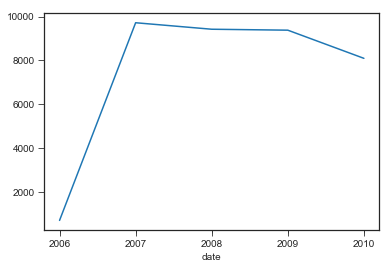

In [35]:
df["energy"].resample("Y").sum().plot()

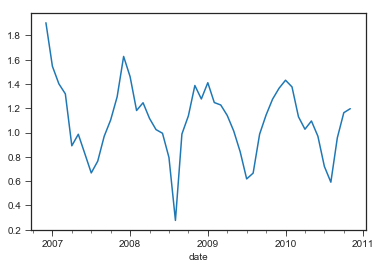

In [36]:
df["energy"].resample("m").mean().plot()

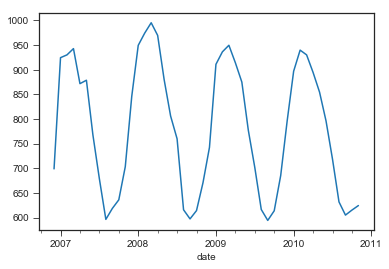

In [37]:
df["energy"].resample("m").sum().rolling(window=5, min_periods=1).mean().plot()

/home/wilam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


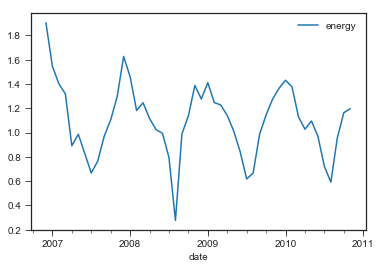

In [38]:
df.groupby(pd.TimeGrouper(freq='m')).mean().plot()

In [39]:
df["month"] = df.index.month
df["hour"] = df.index.hour
df["year"] = df.index.year
df["day"] = df.index.day_name()
df["day2"] = df.index.dayofweek
df["dayMonth"] = df.index.day

day
Monday       0.999630
Tuesday      1.069816
Wednesday    1.082855
Thursday     0.982008
Friday       1.043383
Saturday     1.248634
Sunday       1.219996
Name: energy, dtype: float64


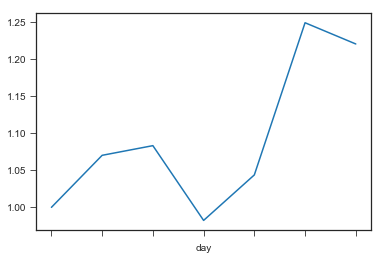

In [40]:
dayStats = df.groupby("day")["energy"].mean()
dayStats = dayStats.reindex(["Monday","Tuesday","Wednesday","Thursday", "Friday", "Saturday","Sunday"])
dayStats.plot()
print(dayStats)

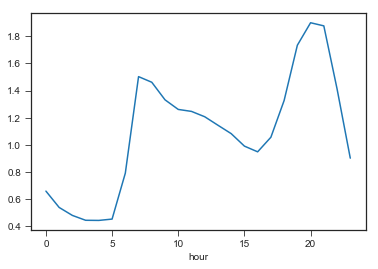

In [41]:
df.groupby("hour")["energy"].mean().plot()
# df.groupby("hour")["energy"].mean()

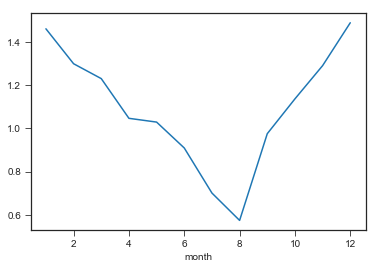

In [42]:
df.groupby("month")["energy"].mean().plot()
# df.groupby("month")["energy"].mean()

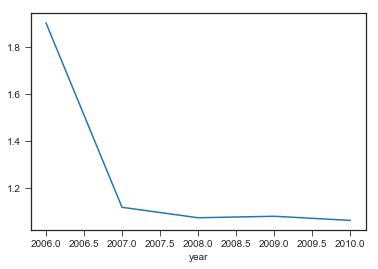

In [43]:
df.groupby("year")["energy"].mean().plot()
# df.groupby("year")["energy"].mean()

In [44]:
df["energy"]= df["energy"].fillna(0)

## Stacjonarność

* Różnice
* Dekompozycja

https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

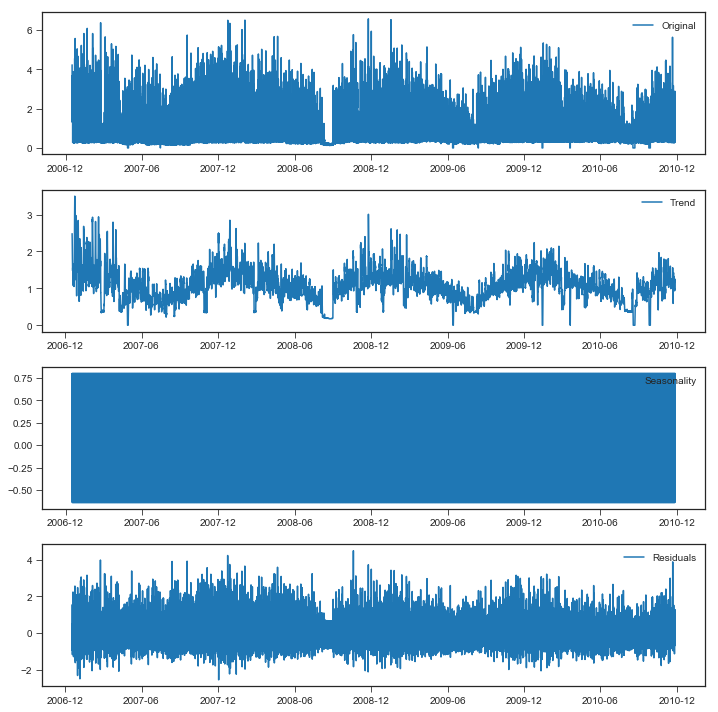

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df["energy"])
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(df["energy"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

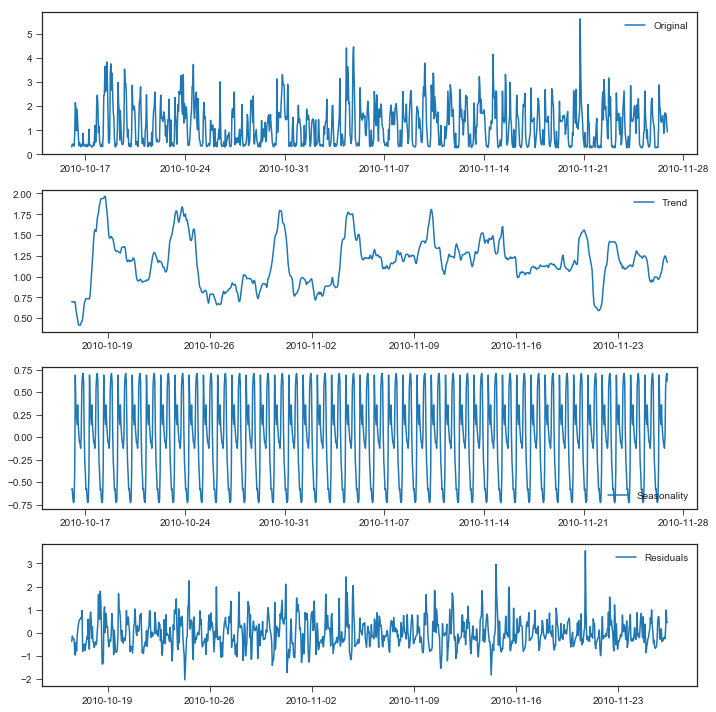

In [46]:
decomposition = seasonal_decompose(df["energy"].loc[df.index > "2010-10-16"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(df["energy"].loc[df.index > "2010-10-16"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [47]:
print(df.shape)
print(df.dropna().shape)
df.dropna(inplace=True)

(34589, 7)
(34589, 7)


In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

features = ['month', 'hour', 'year', 'day2']
clf = RandomForestRegressor(n_estimators=100)
clf = clf.fit(df[features], df["energy"])
df["pred"] = clf.predict(df[features])

mean_squared_error(df["energy"], clf.predict(df[features]))

0.347655279418155

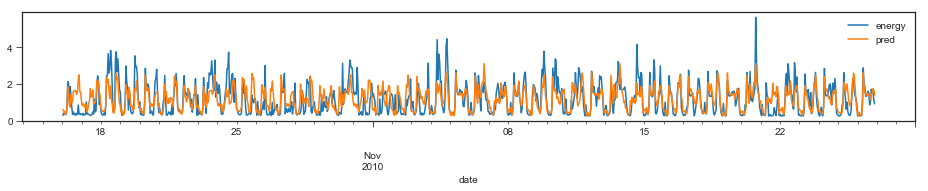

In [49]:
fig, ax = plt.subplots(figsize=(16,2))
df[["energy", "pred"]].loc[df.index > "2010-10-16"].plot(ax=ax)

In [50]:
df["lag1"] = df.energy.shift(1)
print(df.shape)
print(df.dropna().shape)
df.dropna(inplace=True)

(34589, 9)
(34588, 9)


In [51]:
features = ['month', 'hour', 'year', 'day2', 'lag1']
clf = RandomForestRegressor(n_estimators=100)
clf = clf.fit(df[features], df["energy"])
df["pred"] = clf.predict(df[features])
mean_squared_error(df["energy"], clf.predict(df[features]))

0.043797043043900336

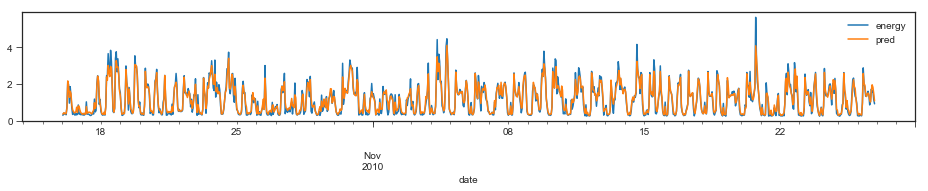

In [52]:
fig, ax = plt.subplots(figsize=(16,2))
df[["energy", "pred"]].loc[df.index > "2010-10-16"].plot(ax=ax)

In [53]:
df["lag2"] = df.energy.shift(2)
print(df.shape)
print(df.dropna().shape)
df.dropna(inplace=True)

(34588, 10)
(34586, 10)


In [54]:
features = ['month', 'hour', 'year', 'day2', 'lag1', 'lag2']
clf = RandomForestRegressor(n_estimators=100)
clf = clf.fit(df[features], df["energy"])
df["pred"] = clf.predict(df[features])
mean_squared_error(df["energy"], clf.predict(df[features]))

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(16,2))
df[["energy", "pred"]].loc[df.index > "2010-10-16"].plot(ax=ax)

Usuwamy rok

In [ ]:
features = ['month', 'hour',  'day2', 'lag1']
clf = RandomForestRegressor(n_estimators=100)
clf = clf.fit(df[features], df["energy"])
df["pred"] = clf.predict(df[features])
print(mean_squared_error(df["energy"], clf.predict(df[features])))
fig, ax = plt.subplots(figsize=(16,2))
df[["energy", "pred"]].loc[df.index > "2010-10-16"].plot(ax=ax)

Sprawdźmy w walidacji krzyżowej

0.3477668060631545


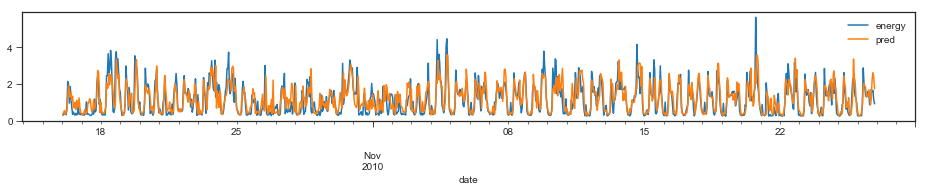

In [55]:
features = ['month', 'hour',  'day2', 'lag1']
clf = RandomForestRegressor(n_estimators=100)
clf = clf.fit(df[features].loc[df.index < "2010-10-16"], df["energy"].loc[df.index < "2010-10-16"])
df["pred"] = clf.predict(df[features])
print(mean_squared_error(df["energy"].loc[df.index > "2010-10-16"], clf.predict(df[features].loc[df.index > "2010-10-16"])))
fig, ax = plt.subplots(figsize=(16,2))
df[["energy", "pred"]].loc[df.index > "2010-10-16"].plot(ax=ax)

In [57]:
df["lag24"] = df.energy.shift(24)
print(df.shape)
print(df.dropna().shape)
df.dropna(inplace=True)

(34586, 11)
(34562, 11)


0.3135913642961964


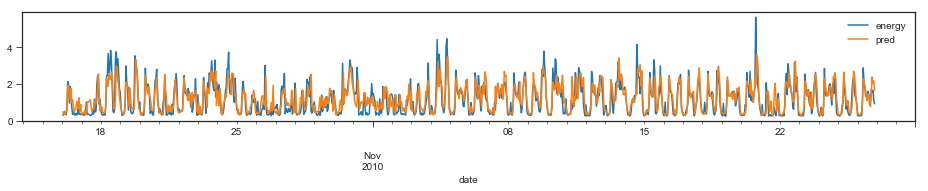

In [58]:
features = ['month', 'hour',  'day2', 'lag1', "lag24"]
clf = RandomForestRegressor(n_estimators=100)
clf = clf.fit(df[features].loc[df.index < "2010-10-16"], df["energy"].loc[df.index < "2010-10-16"])
df["pred"] = clf.predict(df[features])
print(mean_squared_error(df["energy"].loc[df.index > "2010-10-16"], clf.predict(df[features].loc[df.index > "2010-10-16"])))
fig, ax = plt.subplots(figsize=(16,2))
df[["energy", "pred"]].loc[df.index > "2010-10-16"].plot(ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))
(df["energy"].loc[df.index > "2010-10-16"]-df["pred"].loc[df.index > "2010-10-16"]).plot(ax=ax)

In [ ]:
features = ['month', 'hour',  'day2', 'lag1']
clf = RandomForestRegressor(n_estimators=100)
clf = clf.fit(df[features].loc[df.index < "2010-10-16"], df["energy"].loc[df.index < "2010-10-16"])
df["pred"] = clf.predict(df[features])
print(mean_squared_error(df["energy"].loc[df.index > "2010-10-16"], clf.predict(df[features].loc[df.index > "2010-10-16"])))
fig, ax = plt.subplots(figsize=(16,2))
df[["energy", "pred"]].loc[(df.index > "2009-12-20") & (df.index < "2010-01-10")].plot(ax=ax)